In [1049]:
import glob
from astropy import table
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
import	multiprocessing as mp
#from plotsettings_py36 import *
from scipy import interpolate
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
import time
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


# (Super) Functions

In [1050]:
def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

In [1051]:
#lam is in angtroms 
#A_v is a user input

import extinction

A_v = 1.0

def Alam(lamin, A_v):

    lam=np.zeros(len(lamin))
    redreturn=np.zeros(len(lamin))

    #Add extinction with R_v= 3.1 and A_v = 1     
    extinction.ccm89(lam, A_v, 3.1)
        
    return redreturn


In [1052]:
def select_templates(DATABASE, TYPES):

       
#    Selects templates of a given type(s) from a template database
    
#    Input: DATEBASE   list of templates
#           TYPES      which types should be selected
    
#    Output: array of templates of given type(s)
       
    database_trunc = list([])
    
    for type in TYPES:
        database_trunc += list([x for x in DATABASE if type in x])
    
    return np.array(database_trunc)

## Get Sigma

In [1053]:
def error_spectra(spec_object):

    error = [] 
    d=[]
    even = spec_object[:,1][::2]
    odd  = spec_object[:,1][1::2] 
    lam  = spec_object[:,0][::2]
    
    if len(even) > len(odd):
        del even[-1]
    elif len(odd) > len(even):
        del odd[-1]
#    if len(even) == len(odd):
#        even == even
#        odd == odd
    
    for i in range(0,len(even)):
        
        c = odd[i] + even[i] 
        d.append(c/2)
    
    for i in range(0, len(even)):
        e = abs(odd[i] - d[i])
        error.append(e)
           
    #print(lam[-1], spec_object[-1,0])

    if len(lam) > len(error):
        error.append(error[-1])
    elif len(error) > len(lam):
        error = error[:-1]

    return np.array([lam,error]).T

# Compute the (Super) fit

In [1054]:
from scipy.interpolate import interp1d


def wrapper_fit(DATABASE):

    """
    Compute the fit
    """
   
    # 1) File i/o
    
    spec_gal    = np.loadtxt(DATABASE['GALAXY'])
    spec_SN     = np.loadtxt(DATABASE['SN'])
    spec_object = np.loadtxt(DATABASE['OBJECT'])
    error       = error_spectra(spec_object)
    #spec_object[:,1]*=10
    print(spec_object)
    print(error)
    print(spec_object[:10,:])
    print(error[:10,:])
    # 3) Interpolate spectra
    
    spec_gal_interp    = interpolate.interp1d(spec_gal[:,0],    spec_gal[:,1],    bounds_error=False, fill_value=np.nan)
    spec_sn_interp     = interpolate.interp1d(spec_SN[:,0],     spec_SN[:,1],     bounds_error=False, fill_value=np.nan)
    spec_object_interp = interpolate.interp1d(spec_object[:,0], spec_object[:,1], bounds_error=False, fill_value=np.nan)
    spec_object_err_interp = interpolate.interp1d(error[:,0],     error[:,1],     bounds_error=False, fill_value=np.nan)
    
    # Determine the common wavelength range
    
    lambda_min = max([spec_gal[:,0][0],  spec_SN[:,0][0],  spec_object[:,0][0]])
    lambda_max = min([spec_gal[:,0][-1], spec_SN[:,0][-1], spec_object[:,0][-1]])
    
    # Truncate wavelength interval
    
    lambda_new= spec_object[:,0][ (spec_object[:,0] >= lambda_min) & (spec_object[:,0] <= lambda_max) ]
    
    # 4) Fit function

    def func(x, b, d):
        return b * spec_sn_interp(x) + d * spec_gal_interp(x)

    # fitting
     
    result = curve_fit(func, lambda_new, spec_object_interp(lambda_new), sigma=spec_object_err_interp(lambda_new))
    print(result)
    popt   = result[0]
    pcov   = result[1]
    
    # Compute chi^2
    sigma  =1

    chi2   = np.sum(((spec_object_interp(lambda_new)-func(lambda_new, *popt))/sigma)**2)
    print(DATABASE['GALAXY'], DATABASE['SN'])

  
    output=table.Table(
            np.array([DATABASE['OBJECT'], DATABASE['GALAXY'], DATABASE['SN'], chi2, popt[0], popt[1], 0, 0, np.sqrt(pcov[0,0]), 0]), 
            names=('OBJECT', 'GALAXY', 'SN', 'CHI2', 'CONST_SN', 'CONST_GAL', 'CONST_EXT', 'CONST_GAL_ERR', 'CONST_SN_ERR', 'CONST_EXT_ERR'), 
            dtype=('S100', 'S100', 'S100', 'f', 'f', 'f', 'f', 'f', 'f', 'f'))
    
    
    return output
    

# Read in spectral database

In [1055]:

templates_gal = glob.glob('rebinned/gal/*')
templates_gal = [x for x in templates_gal if 'CVS' not in x and 'README' not in x]
templates_gal = np.array(templates_gal)

templates_sn = glob.glob('rebinned/sne/**/*')
templates_sn = [x for x in templates_sn if 'CVS' not in x and 'README' not in x]
templates_sn = np.array(templates_sn)

#These parameters are user inputs 
templates_dust = np.array([-0.2, 0.1])

## Truncate templates SN, HG


In [1056]:
#Truncate the SN 
#templates_sn_trunc = select_templates(templates_sn, ['/Ia/' , '/Ib/' , '/Ic/','/II/'])
templates_sn_trunc = select_templates(templates_sn, ['/Ic/'])

#Truncate the host galaxy
templates_gal_trunc = select_templates(templates_gal, ['/SB6'])


# Compute the cartesian product of SN templates, galaxy templates and extinction measurements

In [1057]:
cartesian_product_all=cartesian_product(*[templates_gal_trunc[:1], templates_sn_trunc, templates_dust[:1]])
cartesian_product_all=table.Table(cartesian_product_all, names=('GALAXY', 'SN', 'DUST'))

#In brakets here is the number of template I'm using to match
cartesian_product_all['OBJECT']=["rebinned/combined/sn1990aa.u00.Ic.SB6"]


cartesian_product_all

GALAXY,SN,DUST,OBJECT
str33,str33,str33,str37
rebinned/gal/SB6,rebinned/sne/Ic/sn1991l.u00.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6
rebinned/gal/SB6,rebinned/sne/Ic/sn1997ef.p108.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6
rebinned/gal/SB6,rebinned/sne/Ic/sn1995f.u57.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6
rebinned/gal/SB6,rebinned/sne/Ic/sn1997ef.p51.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6
rebinned/gal/SB6,rebinned/sne/Ic/sn1997ef.p40.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6
rebinned/gal/SB6,rebinned/sne/Ic/sn2002ap.max.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6
rebinned/gal/SB6,rebinned/sne/Ic/sn1990b.p22.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6
rebinned/gal/SB6,rebinned/sne/Ic/sn1991n.u251.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6
rebinned/gal/SB6,rebinned/sne/Ic/sn1998bw.p09.dat,-0.2,rebinned/combined/sn1990aa.u00.Ic.SB6


In [1058]:
index_array=range(len(cartesian_product_all))
index_array

range(0, 61)

In [1059]:
output=wrapper_fit(cartesian_product_all[0])
output

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

OBJECT,GALAXY,SN,CHI2,CONST_SN,CONST_GAL,CONST_EXT,CONST_GAL_ERR,CONST_SN_ERR,CONST_EXT_ERR
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32,float32,float32
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1991l.u00.dat,4.436493,0.8086382,1.2482895,0.0,0.0,0.0528565,0.0


In [1060]:
if mp.cpu_count() > 1:
     number_cpu	= mp.cpu_count()/2	# is equal to number of threads x number of physical cpus, e.g. 2x4
else:
    number_cpu	= mp.cpu_count()
number_cpu
pool	= mp.Pool(processes=int(number_cpu)*2)


[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]]

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.4271

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.607

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]](array([-0.1317145 ,  2.18185394]), array([[ 0.00051639, -0.00052199],
       [-0.00052199,  0.00059664]]))
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]](array([-0.07603521,  2.12913754]), array([[ 0.00079238, -0.00083814],
       [-0.00083814,  0.00096255]]))
(array([0.80863819, 1.24828941]), array([[ 0.00279381, -0.00263131],
       [-0.00263131, 

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.0083

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]


[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]]

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.4271

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.008397

 [9.65814393e+03 5.03525897e-02]]


[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.2

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.67818594e+03 1.67867387e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.65814393e+03 5.03525897e-02]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.008397

 [9.67818594e+03 1.67867387e+00]]
rebinned/gal/SB6 rebinned/sne/Ic/sn1994I.p02.dat

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.476982

 [9.67818594e+03 1.67867387e+00]]rebinned/gal/SB6 rebinned/sne/Ic/sn1991n.u251.dat

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.022239

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.008397

 [9.65814393e+03 5.03525897e-02]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.206

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]

(array([-0.2515493 ,  2.25950481]), array([[ 0.0007601 , -0.00063695],
       [-0.00063695,  0.00059249]]))
rebinned/gal/SB6 rebinned/sne/Ic/sn1998bw.m07.dat
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.65814393e+03 5.03525897e-02]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.008397

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.65814393e+03 5.03525897e-02]]

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.0083

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]

(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]

rebinned/gal/SB6 rebinned/sne/Ic/sn1991a.u48.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02

 [9.67818594e+03 1.67867387e+00]]rebinned/gal/SB6 rebinned/sne/Ic/sn1994I.p11.dat

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.4769825

 [9.67818594e+03 1.67867387e+00]]

(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))
rebinned/gal/SB6 rebinned/sne/Ic/sn1998bw.p01.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
(array([0.26130651, 1.77915956]), array([[ 0.00134183, -0.0013947 ],
       [-0.0013947 ,  0.00151506]]))

rebinned/gal/SB6 rebinned/sne/Ic/sn2002ap.p29.dat
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.206

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.67818594e+03 1.67867387e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03

 [9.67818594e+03 1.67867387e+00]]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))
rebinned/gal/SB6 rebinned/sne/Ic/sn1995f.u29.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.67818594e+03 1.67867387e+00]](array([1., 1.]), array([[inf, inf],
       [inf, inf]]))

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 

 [9.67818594e+03 1.67867387e+00]]rebinned/gal/SB6 rebinned/sne/Ic/sn2002bj.p11.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.4769825

 [9.65814393e+03 5.03525897e-02]]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]

rebinned/gal/SB6 rebinned/sne/Ic/sn2002ap.p05.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92

 [9.67818594e+03 1.67867387e+00]]rebinned/gal/SB6 rebinned/sne/Ic/sn1999bv.u00.dat

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.476982

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+0

 [9.67818594e+03 1.67867387e+00]]rebinned/gal/SB6 rebinned/sne/Ic/sn1990aa.u62.dat

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.476982

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.0263

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))

rebinned/gal/SB6 rebinned/sne/Ic/sn1997dq.u202.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.67818594e+03 1.67867387e+00]]


[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]](array([1., 1.]), array([[inf, inf],
       [inf, inf]]))
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+0

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.008397

 [9.65814393e+03 5.03525897e-02]](array([0.1868455 , 1.80157752]), array([[ 0.00020709, -0.00027541],
       [-0.00027541,  0.00041228]]))
rebinned/gal/SB6 rebinned/sne/Ic/sn1988l.u48.dat

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 

 [9.67818594e+03 1.67867387e+00]]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))
rebinned/gal/SB6 rebinned/sne/Ic/sn1998bw.m02.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]


 [9.67818594e+03 1.67867387e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.2267

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.65814393e+03 5.03525897e-02]]

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]rebinned/gal/SB6 rebinned/sne/Ic/sn1991a.u17.dat

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063

 [9.67818594e+03 1.67867387e+00]]
rebinned/gal/SB6 rebinned/sne/Ic/sn1990b.p04.dat

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.476982

 [9.67818594e+03 1.67867387e+00]]rebinned/gal/SB6 rebinned/sne/Ic/sn1997dq.u61.dat

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.022239

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.008397

 [9.65814393e+03 5.03525897e-02]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.427179

 [9.67818594e+03 1.67867387e+00]]


[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]][[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.67818594e+03 1.67867387e+00]]
(array([-0.00769936,  2.06112199]), array([[ 0.00078879, -0.0008999 ],
       [-0.0008999 ,  0.0011003 ]]))
rebinned/gal/SB6 rebinned/sne/Ic/sn1991a.u11.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))

rebinned/gal/SB6 rebinned/sne/Ic/sn1991a.u00.dat
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]

 [9.67818594e+03 1.67867387e+00]][[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.206

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.206

 [9.67818594e+03 1.67867387e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839

In [1061]:
result = pool.map(wrapper_fit, cartesian_product_all)

In [1062]:
result=table.vstack(result)

In [1063]:
result=[wrapper_fit(x) for x in cartesian_product_all]
result=table.vstack(result)

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]
 [4.24680103e+03 5.19638653e-02]
 [4.28688505e+03 3.51188823e-02]
 [4.32696907e+03 1.66072608e-02]
 [4.36705309e+03 2.09459825e-02]
 [4.40713711e+03 4.02271149e-02]
 [4.44722113e+03 1.78265543e-02]
 [4.48730516e+03 4.54556333e-02]
 [4.52738918e+03 3.14247019e-02]
 [4.56747320e+03 3.18751517e-02]
 [4.60755722e+03 5.07343559e-02]
 [4.64764124e+03 1.25581078e-02]
 [4.68772526e+03 2.20445566e-02]
 [4.72780929e+03 7.27982409e-03]
 [4.76789331e+03 5.50646018e-03]
 [4.80797733e+03 7.04473943e-03]
 [4.84806135e+03 9.20721202e-02]
 [4.88814537e+03 2.32946572e-02]
 [4.92822939e+03 2.47698251e-02]
 [4.96831341e+03 5.98961503e-02]
 [5.00839744e+03 1.42838257e-01]
 [5.048481

In [1064]:
result.sort('CHI2')
result

OBJECT,GALAXY,SN,CHI2,CONST_SN,CONST_GAL,CONST_EXT,CONST_GAL_ERR,CONST_SN_ERR,CONST_EXT_ERR
bytes100,bytes100,bytes100,float32,float32,float32,float32,float32,float32,float32
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1990aa.u00.dat,0.0,1.0,1.0,0.0,0.0,inf,0.0
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1991l.u00.dat,4.436493,0.8086382,1.2482895,0.0,0.0,0.0528565,0.0
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1990b.p39.dat,5.5093017,0.40428036,1.6516296,0.0,0.0,0.037446044,0.0
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1990b.p04.dat,6.005053,0.22428249,1.8284748,0.0,0.0,0.03908114,0.0
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1995bb.u00.dat,7.305723,0.07257209,1.9225923,0.0,0.0,0.016999116,0.0
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1994I.p01.dat,8.809348,0.3343274,1.6993723,0.0,0.0,0.04976843,0.0
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1988l.u00.dat,8.839155,0.13290934,1.903111,0.0,0.0,0.032811545,0.0
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1994I.p11.dat,10.060541,-0.062743835,2.0757036,0.0,0.0,0.026846588,0.0
rebinned/combined/sn1990aa.u00.Ic.SB6,rebinned/gal/SB6,rebinned/sne/Ic/sn1991k.u14.dat,10.800945,0.05096161,1.9437852,0.0,0.0,0.020468067,0.0


# (Super) Graph

In [1065]:
def visualise_match(DATABASE):

    # File i/o
    
#    print(DATABASE)
    
    spec_gal    = np.loadtxt(DATABASE['GALAXY'][0])
    spec_SN     = np.loadtxt(DATABASE['SN'][0])
    spec_object = np.loadtxt(DATABASE['OBJECT'][0])
    #spec_object[:,1]*=10

    # Plot data
    """
    bestfit_galaxy = DATABASE['GALAXY'].split('/')[-1]
    bestfit_sn_name = DATABASE['SN'].split('/')[2].split('.')[0]
    bestfit_sn_type = DATABASE['SN'].split('/')[1]
    bestfit_sn_phase = '+' + DATABASE['SN'].split('/')[2].split('.')[1].replace('p', '') if 'p' in DATABASE['SN'].split('/')[2].split('.')[1] else '-' + DATABASE['SN'].split('/')[2].split('.')[1].replace('m', '')
    """

    plt.figure(figsize=(7*np.sqrt(2), 7))
    
    ax = plt.subplot(111)
    ax.plot(spec_object[:,0], spec_object[:,1], lw=4, label='Input spectrum')
    ax.plot(spec_gal[:,0], DATABASE['CONST_GAL'] * spec_gal[:,1], lw=1, label='Galaxy template')#: {}'.format(bestfit_galaxy))
    ax.plot(spec_SN[:,0],  DATABASE['CONST_SN']  * spec_SN[:,1],  lw=1, label='SN template')#: {name} ({type}, {phase} days)'.format(type=bestfit_sn_type, name=bestfit_sn_name, phase=bestfit_sn_phase))
    
    ax.legend()#fontsize=legend_size-4)
    
    ax.set_xlabel('Observed wavelength (\\AA)')
    ax.set_ylabel('Flux density (arbitary units)')
    
    ax.set_xlim(spec_object[0,0]-20, spec_object[-1,0]-20)
    ax.set_ylim(0, max(spec_object[:,1])*1.2)
    
    plt.show()


In [1066]:
result[0]['OBJECT']

'rebinned/combined/sn1990aa.u00.Ic.SB6'

<Table length=1>
     name      dtype  
------------- --------
       OBJECT bytes100
       GALAXY bytes100
           SN bytes100
         CHI2  float32
     CONST_SN  float32
    CONST_GAL  float32
    CONST_EXT  float32
CONST_GAL_ERR  float32
 CONST_SN_ERR  float32
CONST_EXT_ERR  float32
None


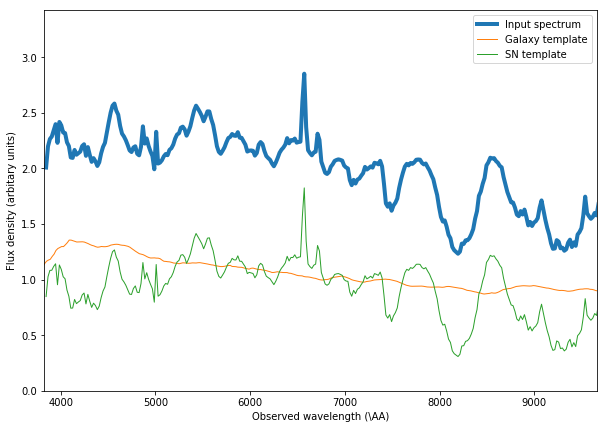

In [1067]:
print(output.info())
visualise_match(table.Table(result[0]))

In [1068]:
import os
os.getcwd()

'/Users/user/Desktop/ssf/superfit'

In [1069]:
[wrapper_fit(x) for x in cartesian_product_all]

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1., 1.]), array([[inf, inf],
       [inf, inf]]))
rebinned/gal/SB6 rebinned/sne/Ic/sn2002ap.p08.dat
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

 [9.65814393e+03 5.03525897e-02]]
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]]
[[3.84596081e+03 9.54182151e-02]
 [3.88604483e+03 1.13209876e-02]
 [3.92612886e+03 2.72891347e-02]
 [3.96621288e+03 9.39808421e-02]
 [4.00629690e+03 3.22383600e-02]
 [4.04638092e+03 4.17029539e-02]
 [4.08646494e+03 5.14121593e-02]
 [4.12654896e+03 3.58063380e-02]
 [4.16663298e+03 7.09160102e-03]
 [4.20671701e+03 2.52935185e-02]]
(array([-0.11993339,  2.16227227]), array([[ 0.00148278, -0.00138392],
       [-0.00138392,  0.00136398]]))
rebinned/gal/SB6 rebinned/sne/Ic/sn2002ap.p14.dat
[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[[3.84596081e+03 2.00810366e+00]
 [3.86600282e+03 2.19894009e+00]
 [3.88604483e+03 2.26434666e+00]
 [3.90608684e+03 2.28698863e+00]
 [3.92612886e+03 2.34370643e+00]
 [3.94617087e+03 2.39828470e+00]
 [3.96621288e+03 2.23015621e+00]
 [3.98625489e+03 2.41811790e+00]
 [4.00629690e+03 2.38729349e+00]
 [4.02633891e+03 2.32281677e+00]
 [4.04638092e+03 2.31806623e+00]
 [4.06642293e+03 2.23466032e+00]
 [4.08646494e+03 2.20132685e+00]
 [4.10650695e+03 2.09850253e+00]
 [4.12654896e+03 2.09467047e+00]
 [4.14659097e+03 2.16628315e+00]
 [4.16663298e+03 2.12322712e+00]
 [4.18667500e+03 2.13741033e+00]
 [4.20671701e+03 2.15106975e+00]
 [4.22675902e+03 2.20165679e+00]
 [4.24680103e+03 2.21734861e+00]
 [4.26684304e+03 2.11342088e+00]
 [4.28688505e+03 2.19203302e+00]
 [4.30692706e+03 2.12179526e+00]
 [4.32696907e+03 2.05912296e+00]
 [4.34701108e+03 2.09233748e+00]
 [4.36705309e+03 2.06413135e+00]
 [4.38709510e+03 2.02223938e+00]
 [4.40713711e+03 2.05524393e+00]
 [4.42717912e+03 2.13569816e+00]
 [4.447221

[<Table length=1>
                 OBJECT                     GALAXY      ... CONST_EXT_ERR
                bytes100                   bytes100     ...    float32   
 ------------------------------------- ---------------- ... -------------
 rebinned/combined/sn1990aa.u00.Ic.SB6 rebinned/gal/SB6 ...           0.0,
 <Table length=1>
                 OBJECT                     GALAXY      ... CONST_EXT_ERR
                bytes100                   bytes100     ...    float32   
 ------------------------------------- ---------------- ... -------------
 rebinned/combined/sn1990aa.u00.Ic.SB6 rebinned/gal/SB6 ...           0.0,
 <Table length=1>
                 OBJECT                     GALAXY      ... CONST_EXT_ERR
                bytes100                   bytes100     ...    float32   
 ------------------------------------- ---------------- ... -------------
 rebinned/combined/sn1990aa.u00.Ic.SB6 rebinned/gal/SB6 ...           0.0,
 <Table length=1>
                 OBJECT              

In [1070]:
#In order to identify the files giving me trouble

for file in np.unique(cartesian_product_all['SN']):
    try:
        np.loadtxt(file)
    except:
        print(file)


In [1071]:
pwd

'/Users/user/Desktop/ssf/superfit'